## This Notebook Uses ReSNet50 (Transfer Learning with PreTrained Weights and Retraining) Model to generate Output Predictions

#<font color='red'> 9. Train Model </font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os

print('CWD is ',os.getcwd())

# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is  /content


In [2]:
def load_data():
  train = pd.read_csv('/content/drive/MyDrive/computer vision/train.csv')
  test = pd.read_csv('/content/drive/MyDrive/computer vision/test.csv')

  train_dir = os.path.join('./','train_images/')
  test_dir = os.path.join('./','test_images/')

  train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
  test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

  train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
  test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

  train['diagnosis'] = train['diagnosis'].astype(str)

  return train, test

In [21]:
df_train, df_test = load_data()
print(df_train.shape, df_test.shape)
df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train_images/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train_images/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train_images/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train_images/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train_images/005b95c28852.png,005b95c28852.png
5,0083ee8054ee,4,./train_images/0083ee8054ee.png,0083ee8054ee.png


In [22]:
df_train_train, df_train_valid = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape, df_train_valid.shape)

(2929, 4) (733, 4)


In [24]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [23]:
PATH = '/content/drive/MyDrive/computer vision'

In [34]:
def img_generator(train, valid, test):
  train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
  train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=f"{PATH}/train_resized_preprocessed/",
                                                    x_col="file_name",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(HEIGHT, WIDTH))

  valid_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
  valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid,
                                                      directory=f"{PATH}/valid_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH))

  test_datagen = ImageDataGenerator(rescale=1./255)
  test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                    directory =f"{PATH}/test_resized_preprocessed/",
                                                    x_col="file_name",
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=1,
                                                    shuffle=False,
                                                    class_mode=None)

  return train_generator,valid_generator,test_generator

In [35]:
train_generator, valid_generator, test_generator = img_generator(df_train_train, df_train_valid, df_test)

Found 2350 validated image filenames belonging to 5 classes.
Found 154 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [44]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(include_top=False,input_tensor=input_tensor)
    # base_model.load_weights('/content/drive/MyDrive/computer vision/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [45]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 160, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [46]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 19


In [47]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
293/293 [==============================] - 1180s 4s/step - loss: 1.9838 - accuracy: 0.4022 - val_loss: 1.5607 - val_accuracy: 0.4408
Epoch 2/2
293/293 [==============================] - 37s 125ms/step - loss: 1.3852 - accuracy: 0.4594 - val_loss: 1.3744 - val_accuracy: 0.4671


In [48]:
for layer in model.layers:
  layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE,
                          factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 326, 326, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 160, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [49]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/40
293/293 [==============================] - 98s 212ms/step - loss: 0.3704 - accuracy: 0.6529 - val_loss: 2.9335 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 2/40
293/293 [==============================] - 59s 202ms/step - loss: 0.3150 - accuracy: 0.6934 - val_loss: 1.4204 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 3/40
293/293 [==============================] - 60s 203ms/step - loss: 0.2953 - accuracy: 0.6827 - val_loss: 0.5215 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
293/293 [==============================] - 60s 204ms/step - loss: 0.2720 - accuracy: 0.7105 - val_loss: 0.2771 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 5/40
293/293 [==============================] - 59s 202ms/step - loss: 0.2614 - accuracy: 0.7216 - val_loss: 0.2762 - val_accuracy: 0.6513 - lr: 0.0010
Epoch 6/40
293/293 [==============================] - 59s 202ms/step - loss: 0.2451 - accuracy: 0.7225 - val_loss: 0.8511 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 7/40
293/293 [==============================] 

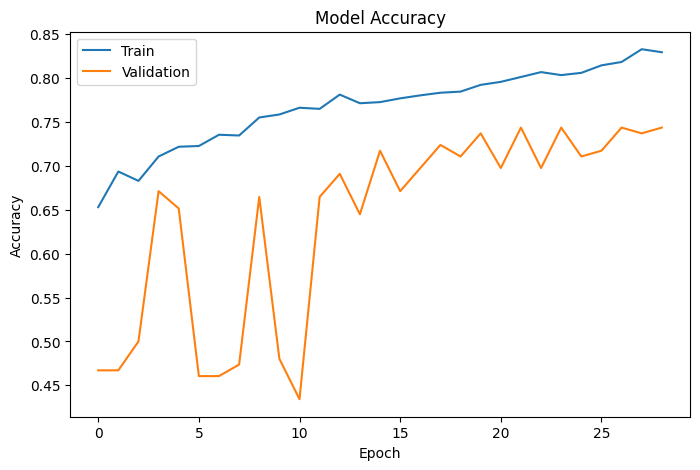

In [50]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

### <font color='red'> 9.1 Evaluate Model </font>

In [57]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

1928/1928 [==============================] - 891s 462ms/step


In [64]:
imgs_df = pd.read_csv('/content/drive/MyDrive/computer vision/check.csv')
def img_generator(imgs):
  datagen = ImageDataGenerator(rescale=1./255)
  generator = datagen.flow_from_dataframe(dataframe=imgs,
                                          directory =f"{PATH}/checked_images/",
                                          x_col="file_name",
                                          target_size=(HEIGHT, WIDTH),
                                          batch_size=1,
                                          shuffle=False,
                                          class_mode=None)

  return generator

In [67]:
checked_generator = img_generator(imgs_df)
STEP_SIZE_CHECK = checked_generator.n//checked_generator.batch_size
checked_preds = model.predict_generator(checked_generator, steps=STEP_SIZE_CHECK, verbose = 1)
checked_labels = [np.argmax(pred) for pred in checked_preds]

Found 3 validated image filenames.
3/3 [==============================] - 0s 20ms/step


In [69]:
imgs_df

,id,file_name,Unnamed: 2,label
0,ff631653374e-0,ff631653374e-0.png,NaN,0
1,fdd534271f3d-4,fdd534271f3d-4.png,NaN,4
2,fc4d69128e7c-2,fc4d69128e7c-2.png,NaN,2


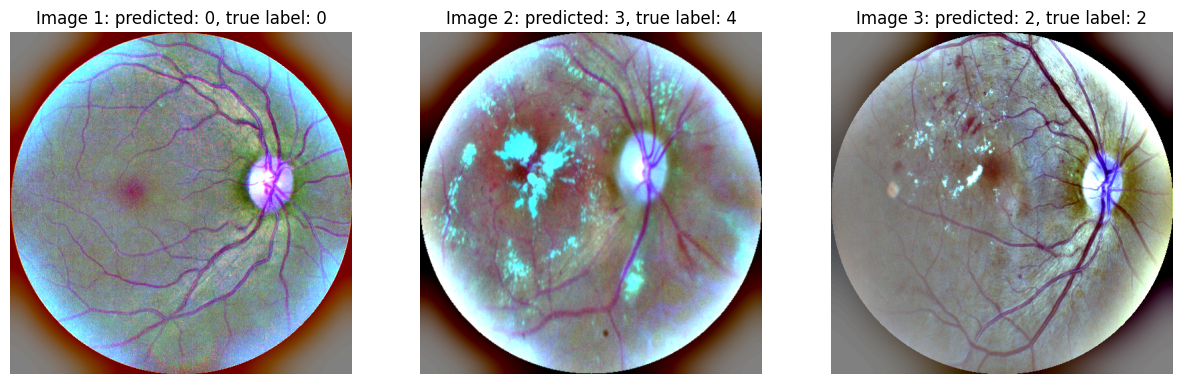

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image1_path = f"{PATH}/checked_images/ff631653374e-0.png"
image2_path = f"{PATH}/checked_images/fdd534271f3d-4.png"
image3_path = f"{PATH}/checked_images/fc4d69128e7c-2.png"

img1 = mpimg.imread(image1_path)
img2 = mpimg.imread(image2_path)
img3 = mpimg.imread(image3_path)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img1)
ax[0].set_title(f'Image 1: predicted: {checked_labels[0]}, true label: {imgs_df.label.values[0]}')
ax[0].axis('off')

ax[1].imshow(img2)
ax[1].set_title(f'Image 2: predicted: {checked_labels[1]}, true label: {imgs_df.label.values[1]}')
ax[1].axis('off')

ax[2].imshow(img3)
ax[2].set_title(f'Image 3: predicted: {checked_labels[2]}, true label: {imgs_df.label.values[2]}')
ax[2].axis('off');

### <font color='red'> 9.2 ResNet50 Models Summary </font>

In [71]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
